In [1]:
import sys
sys.path.append("../scripts")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from labels import label_names_dict

In [2]:
def load_gp_data(path, name):
    
    with open(path) as f:
        gp_df = pd.read_json(f)
        gp_df['model'] = name
        
    return gp_df

def load_gpar_data(path, name, matrix_factorized=False):
    
    with open(path) as f:
        gpar_data = pd.read_json(f)
        
        dfs = []
        for i, row in gpar_data.iterrows():
            df = pd.DataFrame({
                'model': name + (("_" + str(row["latent_size"])) if matrix_factorized else ""),
                'index': row['index'],
                'output': row['outputs'],
                'size': row["size"],
#                 "train_time": row["train_time"],
#                 "predict_time": row["predict_time"],
                "rmse": row["rmse"],
                "mean_abs_err": row["mean_abs_err"],
                "mean_squ_err": row["mean_squ_err"]
            })
            
            dfs.append(df)
        
    return pd.concat(dfs, axis=0, ignore_index=True)

In [3]:
def plot_stats(aggregate, stat: str):
    line_style_dict = {
        "gp": "solid",
        "gpar": "dashed",
        "gp_aux": "dotted",
        "mf_gpar_5": "dashdot"
    }
    
    model_label = {
        "gp": "GP",
        "gpar": "GPAR",
        "gp_aux": "GP-aux",
        "mf_gpar_5": "MF-GPAR (5)"
    }
    
    outputs = ["avg_power", "cycle", "total_area"]
    
    fig, axes = plt.subplots(nrows=1, ncols=len(outputs), figsize=(4 * len(outputs), 4))
    
    # Plot the outputs of interest
    for output, group in aggregate.groupby('output'):
        
        if output not in outputs: 
            continue
            
        ax = axes[outputs.index(output)]
        
        # Plot each model's performance on the current output
        for model, subgroup in group.groupby('model'):
            
            if model not in line_style_dict.keys(): 
                continue
                
            d = subgroup.sort_values("size")
            
            # Interpolated plot of performance
            ax.plot(d["size"],
                    d[(stat, 'mean')],
                    label=model_label[model],
                   c="black",
                   linestyle=line_style_dict[model],
                   zorder=-1)
            
            # Plot actual points
            ax.scatter(d['size'],
                      d[(stat, 'mean')],
                      s=30,
                      c="white",
                      edgecolors='black',
                      zorder=1,
                      label=None)
            
            # Plot error bars
            ax.errorbar(d['size'],
                       d[(stat, 'mean')],
                       yerr=d[(stat, 'std')],
                       ecolor='black',
                       fmt='None',
                       capsize=3,
                       zorder=-1,
                       label=None)
            
            ax.set_xlim([15, 210])
            
            ax.set_ylabel('MAE '+ label_names_dict[output], fontsize=12)
            ax.set_xlabel('Dataset Size', fontsize=12)
            
        ax.legend()
        
    fig.tight_layout()
    return fig

In [77]:
def comparison_plots(old_stats, new_stats, old_model: str, new_model: str, stat: str):
    line_style_dict = {
        "gp": "solid",
        "gpar": "dashed",
        "gp_aux": "dotted",
        "mf_gpar_5": "dashdot"
    }
    
    model_label = {
        "gp": "GP",
        "gpar": "GPAR",
        "gp_aux": "GP-aux",
        "mf_gpar_5": "MF-GPAR (5)"
    }
    
    old_df = old_stats[old_stats.model == old_model]
    new_df = stats[stats.model == new_model]
    
    outputs = ["avg_power", "cycle", "total_area"]
    
    fig, axes = plt.subplots(nrows=1, ncols=len(outputs), figsize=(4 * len(outputs), 4))
    
    fig.suptitle(f"Old {model_label[old_model]} - New {model_label[new_model]} performance comparison")
    
    # Plot the outputs of interest
    for (old_output, old_group), (new_output, new_group) in zip(old_df.groupby('output'), new_df.groupby('output')):
        
        if old_output not in outputs or new_output not in outputs: 
            continue
            
        ax = axes[outputs.index(old_output)]
        
        #-------------------------------------------
        # plot old stuff
        #-------------------------------------------
        d = old_group.sort_values("size")

        # Interpolated plot of performance
        ax.plot(d["size"],
                d[(stat, 'mean')],
                label=f"Old {model_label[old_model]}",
               c="black",
               linestyle=line_style_dict[old_model],
               zorder=-1)

        # Plot actual points
        ax.scatter(d['size'],
                  d[(stat, 'mean')],
                  s=30,
                  c="white",
                  edgecolors='black',
                  zorder=1,
                  label=None)

        # Plot error bars
        ax.errorbar(d['size'],
                   d[(stat, 'mean')],
                   yerr=d[(stat, 'std')],
                   ecolor='black',
                   fmt='None',
                   capsize=3,
                   zorder=-1,
                   label=None)

        #-------------------------------------------
        # plot new stuff
        #-------------------------------------------
        d = new_group.sort_values("size")

        # Interpolated plot of performance
        ax.plot(d["size"],
                d[(stat, 'mean')],
                label=f"New {model_label[new_model]}",
               c="red",
               linestyle=line_style_dict[new_model],
               zorder=-1)

        # Plot actual points
        ax.scatter(d['size'],
                  d[(stat, 'mean')],
                  s=30,
                  c="white",
                  edgecolors='black',
                  zorder=1,
                  label=None)

        # Plot error bars
        ax.errorbar(d['size'],
                   d[(stat, 'mean')],
                   yerr=d[(stat, 'std')],
                   ecolor='black',
                   fmt='None',
                   capsize=3,
                   zorder=-1,
                   label=None)
        
        ax.set_xlim([15, 210])

        ax.set_ylabel('MAE '+ label_names_dict[old_output], fontsize=12)
        ax.set_xlabel('Dataset Size', fontsize=12)
            
        ax.legend()
        
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.5, top=0.9)
    return fig   

In [78]:
old_data_path = {
    "fft": "../../old-boa-data/data/fft/pred",
    "stencil3d": "../../old-boa-data/data/stencil3d/pred"
}

new_data_path = {
    "fft": "../logs/fft/pred",
    "stencil3d": "../logs/stencil3d/pred"
}

old_ff_gp_file = "gp_runs.json"
old_ff_gp_aux_file = "gp_aux_runs.json"
old_gpar_file = "gpar_runs.json"
old_mf_gpar_file = "mf_gpar_runs.json"

ff_gp_file = "ff-gp_experiments.json"
ff_gp_aux_file = "ff-gp-aux_experiments.json"
gpar_file = "gpar_experiments.json"
mf_gpar_file = "mf-gpar_experiments.json"

# Load the experimental data
old_gp_df = load_gp_data(os.path.join(old_data_path["fft"], old_ff_gp_file), name="gp")
old_gp_aux_df = load_gp_data(os.path.join(old_data_path["fft"], old_ff_gp_aux_file), name="gp_aux")
old_gpar_df = load_gpar_data(os.path.join(old_data_path["fft"], old_gpar_file), 
                             name="gpar",
                             matrix_factorized=False)
old_mf_gpar_df = load_gpar_data(os.path.join(old_data_path["fft"], old_mf_gpar_file), 
                                name="mf_gpar",
                                matrix_factorized=True)

gp_df = load_gpar_data(os.path.join(new_data_path["fft"], ff_gp_file), name="gp")
# gp_df = gp_df[gp_df["size"] > 25]

gp_aux_df = load_gp_data(os.path.join(new_data_path["fft"], ff_gp_aux_file), name="gp_aux")
# gp_aux_df = gp_aux_df[gp_aux_df["size"] > 25]

gpar_df = load_gpar_data(os.path.join(new_data_path["fft"], gpar_file), 
                         name="gpar",
                         matrix_factorized=False)
# gpar_df = gpar_df[gpar_df["size"] > 25]
mf_gpar_df = load_gpar_data(os.path.join(new_data_path["fft"], mf_gpar_file), 
                         name="mf_gpar",
                         matrix_factorized=True)

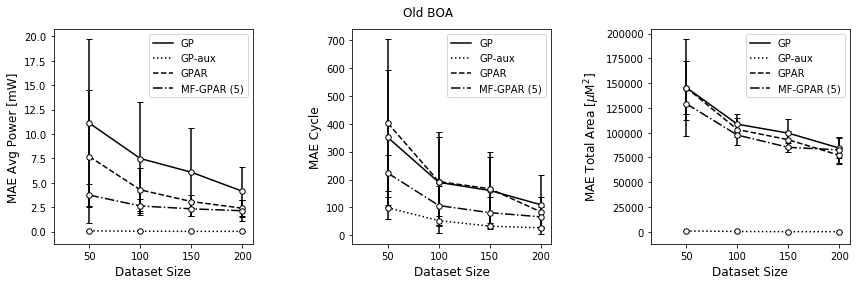

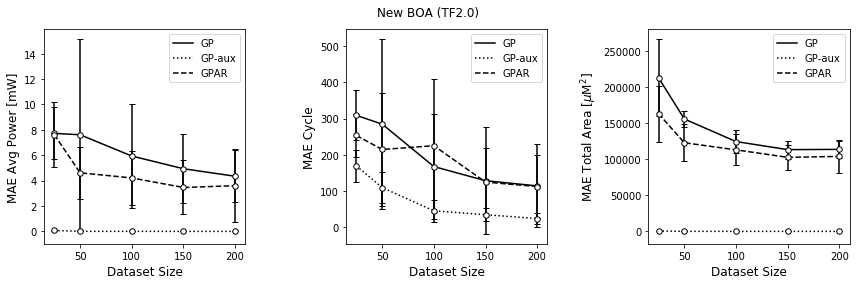

In [79]:
# Aggregate the stuff we want to plot
# Old stuff
old_aggregated = pd.concat([old_gp_df, old_gp_aux_df, old_gpar_df, old_mf_gpar_df], 
                           sort=False, axis=0, ignore_index=True)

old_stats = old_aggregated.groupby(['model', 'output', 'size'])
old_stats = old_stats.aggregate({"mean_abs_err": [np.mean, np.std]}).reset_index()

# New data
aggregated = pd.concat([gp_df, gp_aux_df, gpar_df], sort=False, axis=0, ignore_index=True)

stats = aggregated.groupby(['model', 'output', 'size'])
stats = stats.aggregate({"mean_abs_err": [np.mean, np.std]}).reset_index()

# Plot the data
old_fig = plot_stats(old_stats, stat="mean_abs_err")
old_fig.suptitle("Old BOA")
old_fig.subplots_adjust(wspace=0.5, top=0.9)

fig = plot_stats(stats, stat="mean_abs_err")
fig.suptitle("New BOA (TF2.0)")
fig.subplots_adjust(wspace=0.5, top=0.9)

plt.show()

/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.
/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


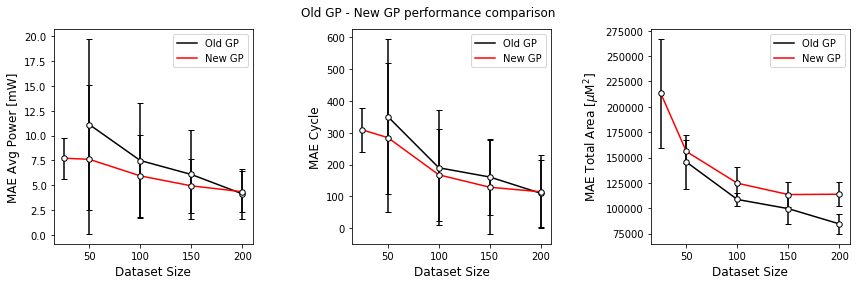

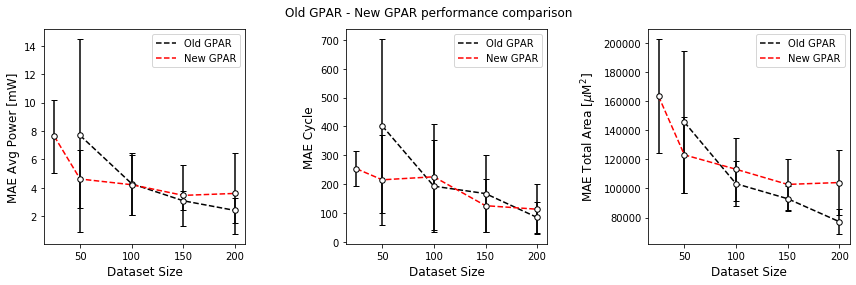

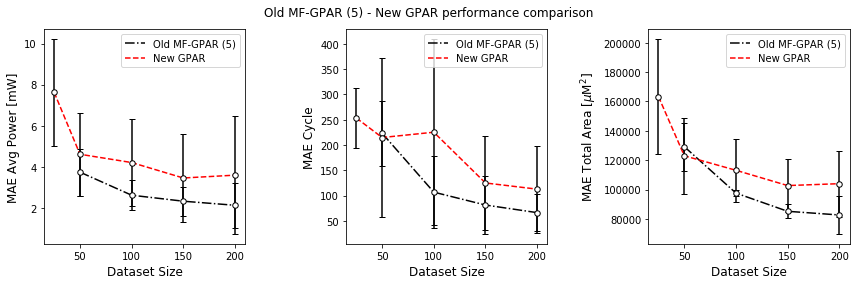

In [80]:
comparison_plots(old_stats, stats, old_model="gp", new_model="gp", stat="mean_abs_err").show()
comparison_plots(old_stats, stats, old_model="gpar", new_model="gpar", stat="mean_abs_err").show()
comparison_plots(old_stats, stats, old_model="mf_gpar_5", new_model="gpar", stat="mean_abs_err").show()